In [1]:
import numpy as np
import pandas as pd
import xarray as xr

from pathlib import Path

import altair as alt
from altair.expr import datum

In [2]:
%load_ext watermark

In [3]:
%watermark --iversions

xarray    0.12.0
altair    3.0.1
pandas    0.24.2
numpy     1.16.3



In [4]:
from utils.load import load_dilution_data
from utils.calculate_metrics import (process_data, relative_errors, summary_errors)

# 1. Load the simulation data

In [5]:
dil_df, debug_info = load_dilution_data()

In [6]:
dil_df.head()

,flux,ID,BiGG_ID,author,sample_id,normalized_flux
0,-0.054344,ACALD,ACALD,Khodayari,0.2,-0.049474
1,-0.004107,ACALDtpp_ex,composed of ACALDtex and ACALDtpp,Khodayari,0.2,-0.003739
2,0.088129,ACKr,ACKr,Khodayari,0.2,0.080232
3,96.831733,ACONTa,ACONTa,Khodayari,0.2,88.154691
4,96.797201,ACONTb,ACONTb,Khodayari,0.2,88.123254


In [7]:
dil_df.sample_id = dil_df.sample_id.astype('str')

In [8]:
dil_df.query("author == 'Yao'").BiGG_ID.unique()

array(['GLCptspp', 'PGI', 'PFK', 'FBA', 'GAPD', 'PGK', 'PGM', 'ENO',
       'PYK', 'PDH', 'PTAr', 'ACKr', 'ACt2r', 'PPC', 'CS', 'ACONTa',
       'ACONTb', 'ICDHyr', 'AKGDH', 'SUCOAS', 'SUCDi', 'FUM', 'ME1',
       'ICL', 'MDH', 'NADTRHD', 'G6PDH2r', 'GND', 'RPE', 'RPI', 'TKT1',
       'TKT2', 'TALA', 'PGCD', 'GHMT2r'], dtype=object)

### Preprocess data

In [9]:
xdf = process_data(dil_df, author="Yao")

# 2. Calculate error metrics

In [10]:
x_rel_error = relative_errors(xdf, author="Yao")

In [11]:
x_norm_error = summary_errors(xdf, author="Yao")

# 3. Visualize

In [12]:
from utils.vis import heatmap, summary_chart, jitter_summary_chart

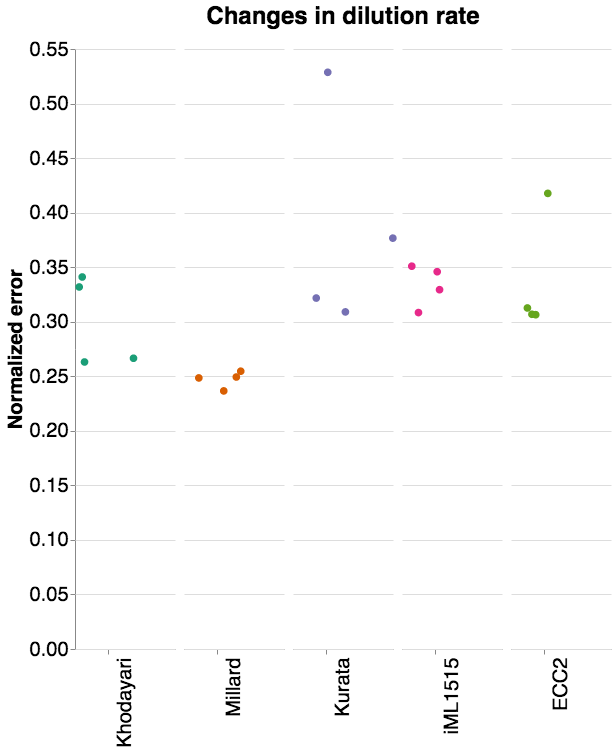

In [13]:
jitter_summary_chart(norm_error = x_norm_error, author = "Yao",
              title= "Changes in dilution rate",
              sort_list=[ "Khodayari",
            "Millard", "Kurata","iML1515", "ECC2"],
                     opacity = False,
              color_scheme = "dark2")

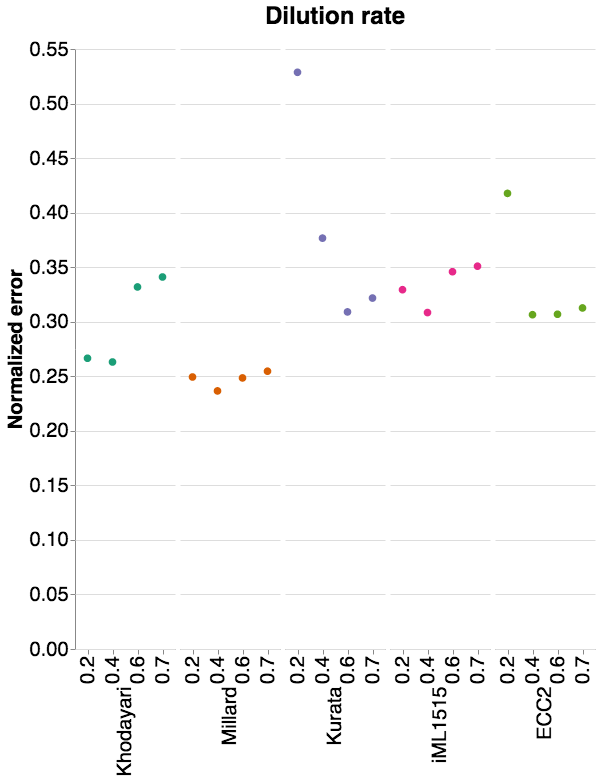

In [20]:
domain = ["Khodayari", "Millard", "Kurata", "iML1515", "ECC2", "Exp_iML1515", "Exp_ECC2"]
range_ = ["#1b9e77", "#d95f02", "#7570b3", "#e7298a", "#66a61e", "#e6ab02", "#a6761d"]

author = "Yao"
sort_list=[ "Khodayari", "Millard", "Kurata","iML1515", "ECC2"],

source = x_norm_error.to_dataframe().reset_index()
if type(author) == list:
    source = source.query(f"author not in @author")
elif type(author) == str:
    source = source.query(f"author != '{author}'")

selector = alt.selection_single(empty="none", fields=["sample_id"])

opacity = alt.OpacityValue(1.0)

size = alt.condition(selector, alt.SizeValue(150), alt.SizeValue(60))

    
stripplot = (
    alt.Chart(source, width=100, height=600)
    .mark_circle()
    .encode(
        x=alt.X(
            "sample_id:O",
            title=None,
            #axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
            scale=alt.Scale(),
        ),
        y=alt.Y("normalized_error:Q", title="Normalized error"),
        color=alt.Color("author:N", legend=None, scale=alt.Scale(domain=domain, range=range_)),
        column=alt.Column(
            "author:N",
            header=alt.Header(
                labelAngle=-90,
                titleOrient="top",
                labelOrient="bottom",
                labelAlign="right",
                labelPadding=3,
                labelFontSize=20,
                title="Dilution rate",
            ),
            sort=["Khodayari", "Millard", "Kurata","iML1515", "ECC2"],
        ),
        size=size,
        opacity=opacity,
        tooltip=["author", "sample_id", "normalized_error"],
    )
    .configure_facet(spacing=5)
    .configure_view(stroke=None)
    .add_selection(selector)
    .transform_filter("datum.normalized_error !== null")
)

stripplot.configure_axis(labelFontSize=20, titleFontSize=20).configure_header(titleFontSize=24)


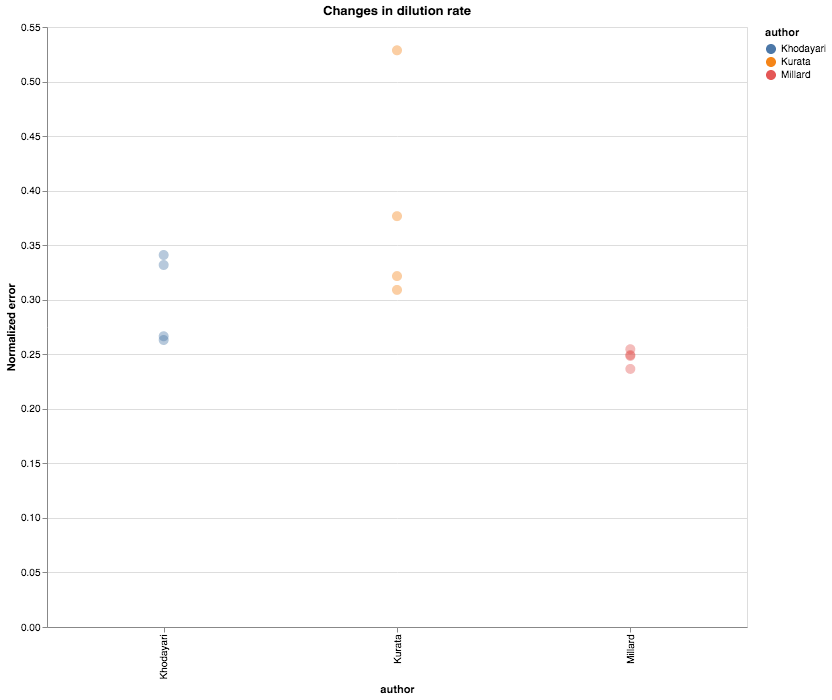

In [14]:
summary_chart(norm_error = x_norm_error, author = "Yao",
              title= "Changes in dilution rate",
              sort_list=[
            "Khodayari",
            "Kurata",
            "Millard"])

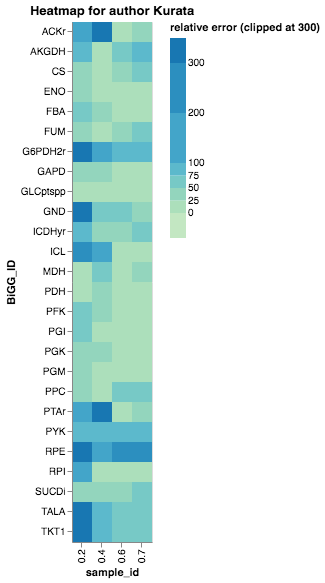

In [16]:
heatmap(x_rel_error, author = "Kurata")

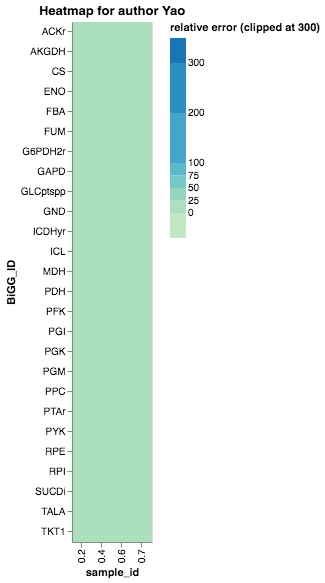

In [15]:
heatmap(x_rel_error, author = "Yao")

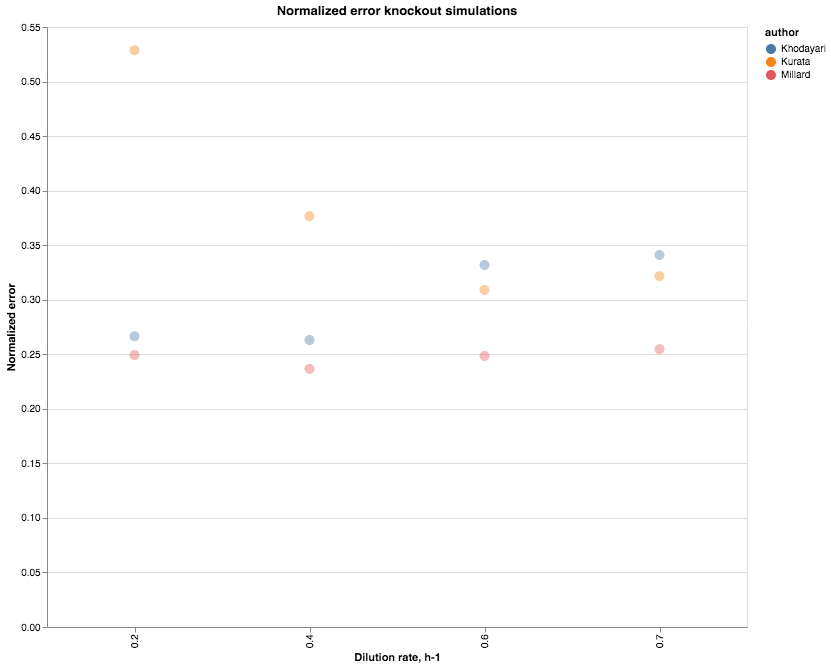

In [11]:
selector = alt.selection_single(empty="all", fields=["sample_id"])
color = alt.condition(
    selector,
    alt.Color(
        "author:N",
        sort=[
            "Khodayari",
            "Kurata",
            "Millard",
            "iML1515",
            "Ec_core",
            "ECC2",
            "Exp_ECC2",
        ],
    ),
    alt.ColorValue("lightgray"),
)

opacity = alt.condition(selector, alt.OpacityValue(0.4), alt.OpacityValue(1.0))

size = alt.condition(selector, alt.SizeValue(100), alt.SizeValue(40))


base = (
    alt.Chart(
        x_norm_error.to_dataframe()
        .reset_index()
        .query("author != 'Yao'"),
        title="Normalized error knockout simulations",
    )
    .mark_circle()
    .encode(
        y=alt.Y("normalized_error", title="Normalized error"),
        tooltip=["author", "sample_id", "normalized_error"],
        x=alt.X("sample_id", sort=["0.2", "0.4", "0.6", "0.7"], title="Dilution rate, h-1"),
        size=size,
        opacity = opacity,
    )
)

errors = (
    base
    .encode(color=color)
    .add_selection(selector)
    .transform_filter("datum.normalized_error !== null")
)

na_vals = base.encode(color=alt.value("lightgrey")).transform_filter("datum.normalized_error === null")


(errors).properties(width=700, height=600).configure_axis(
    labelFontSize=24, titleFontSize=24
).configure_legend(labelFontSize=16, titleFontSize=20).configure(invalidValues=None)
